# Задание

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
daily_total_female = pd.read_csv('daily-total-female-births-in-cal.csv')
airline_passengers = pd.read_csv('international-airline-passengers.csv')

## Функции

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# Изучим стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


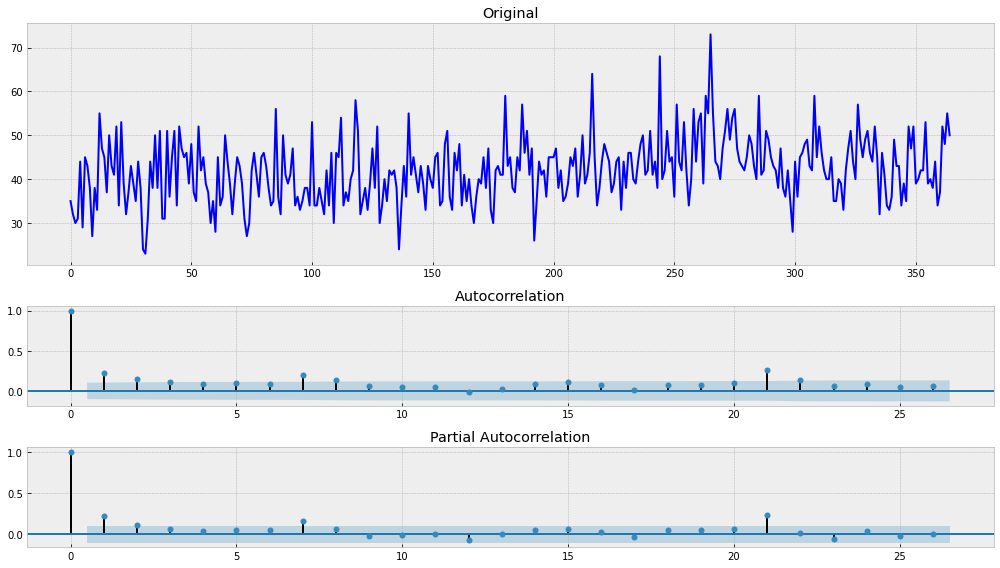

In [ ]:
tsplot(daily_total_female['Count'])

## MA - скользящее среднее

In [ ]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

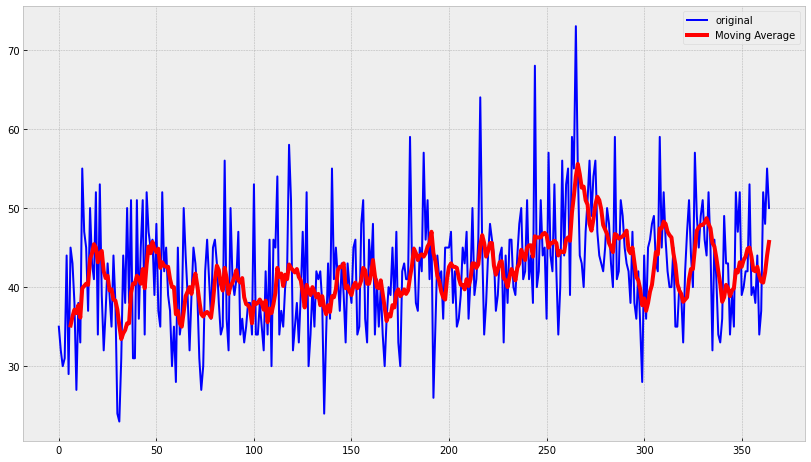

In [ ]:
ser = moving_average(daily_total_female['Count'], 7)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(daily_total_female['Count'], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

## WMA - взвешенная скользящая средняя

In [ ]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

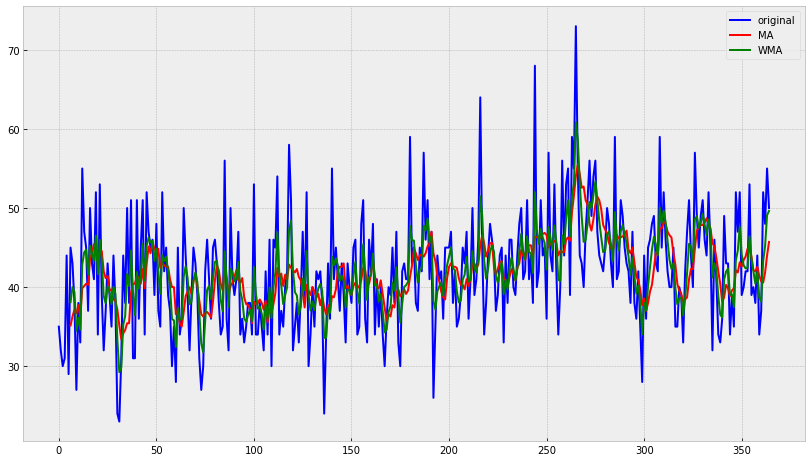

In [ ]:
wma = weighted_moving_average(daily_total_female['Count'], 7, [1,1,2,3,5,8,13])
ma = moving_average(daily_total_female['Count'], 7)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(daily_total_female['Count'], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

## EMA - экспоненциальное сглаживание

In [ ]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

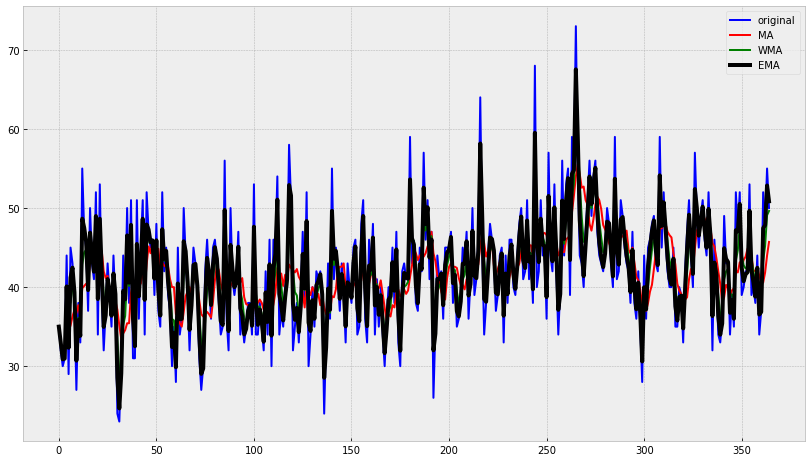

In [ ]:
ema = exponential_moving_average(daily_total_female['Count'], 0.7)
wma = weighted_moving_average(daily_total_female['Count'], 7, [1,1,2,3,5,8,13])
ma = moving_average(daily_total_female['Count'], 7)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(daily_total_female['Count'], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

с коэффициентом α = 0.5 EMA повторят путь WMA

## DEMA - двойное экспоненциальное сглаживание

In [ ]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [ ]:
def plot_dema(alpha, beta):
    dema = double_ema(daily_total_female['Count'], alpha, beta)

    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(daily_total_female['Count'], color='blue',label='original')
        plt.plot(dema, color='purple', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

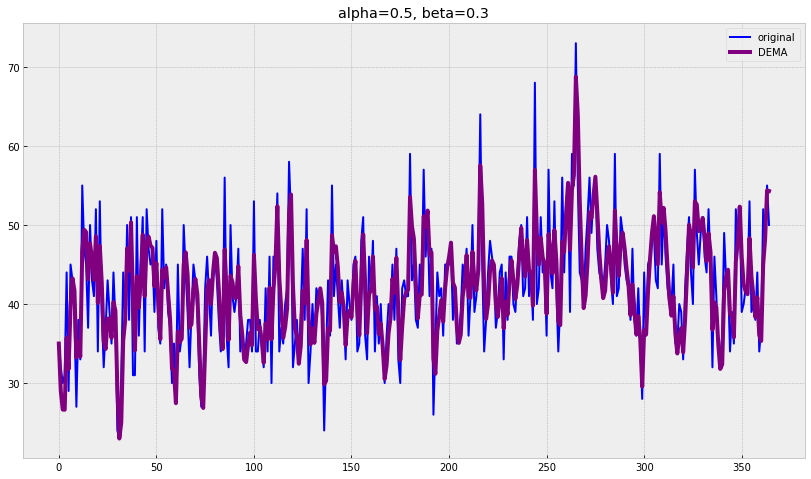

In [ ]:
plot_dema(0.5, 0.3)

с коэффициентами α = 0.5 и β = 0.3 DEMA неплохо описывает данные

## TEMA - Хольт-Винтерс (учтем сезонность)

In [ ]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = sum([float(series[i + slen] - series[i]) / slen]) / slen
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


def plot_tema(alpha, beta, gamma, ser=daily_total_female['Count'], ser_to_plot=daily_total_female['Count'], n_preds=10):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

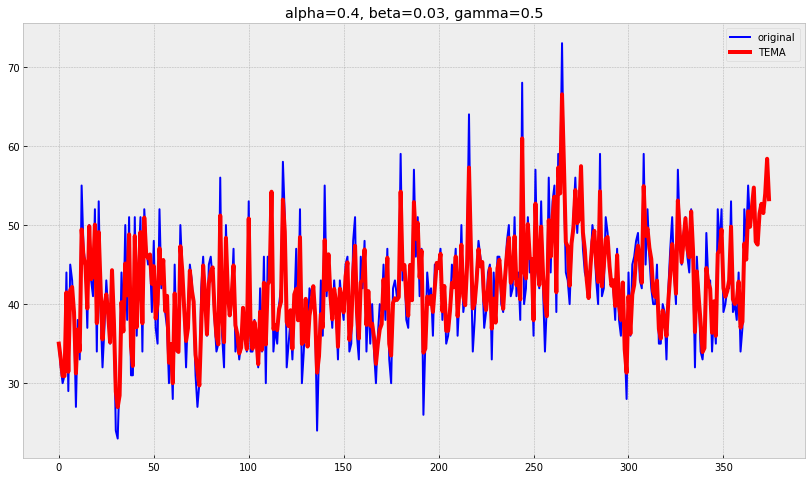

In [ ]:
plot_tema(0.4, 0.03, 0.5)

## Подбор параметров

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [ ]:
series = daily_total_female["Count"]
train, test, val = series[:60], series[60:70], series[70:]

In [ ]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0.4, 0.03, 0.5], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 64.21043518518334
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([524.85726911,   0.        ,  63.47764554])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


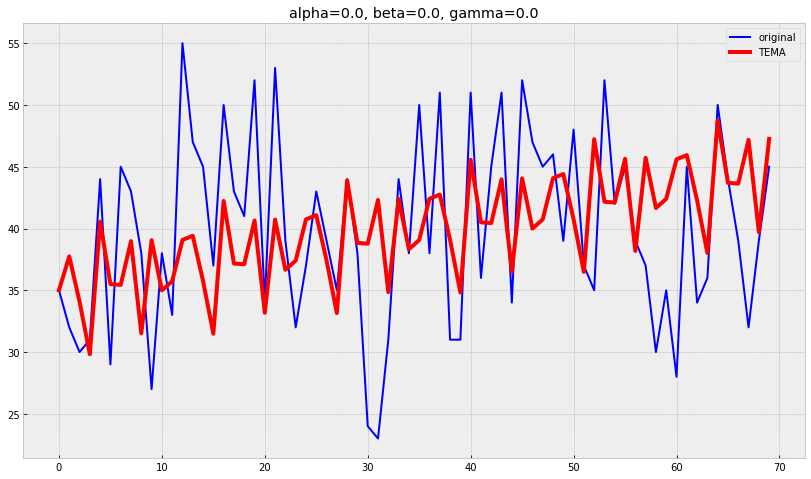

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

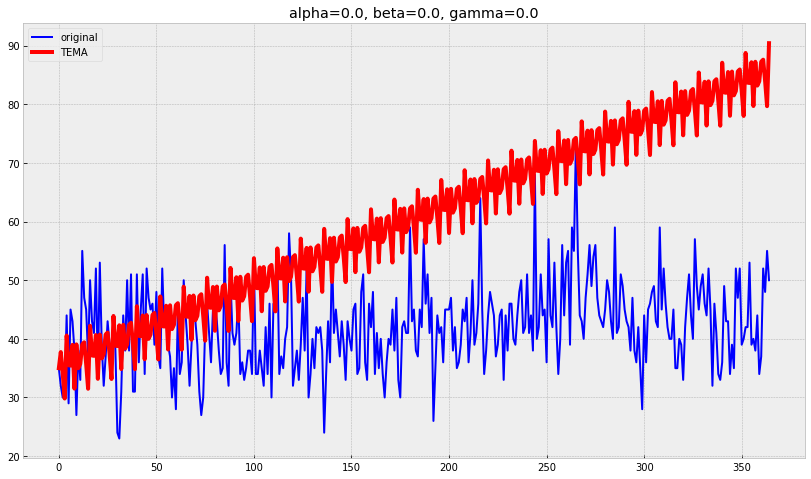

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

## Кросс-валидация

In [ ]:
train, val = series[:65], series[65:]

from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [ ]:
#opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

90.50962898662532------------
90.50963054551534------------
90.50962898662532------------
90.50962901213553------------
      fun: 90.50962898662532
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([155.88900197,   0.        ,   2.55102179])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([0., 0., 0.])


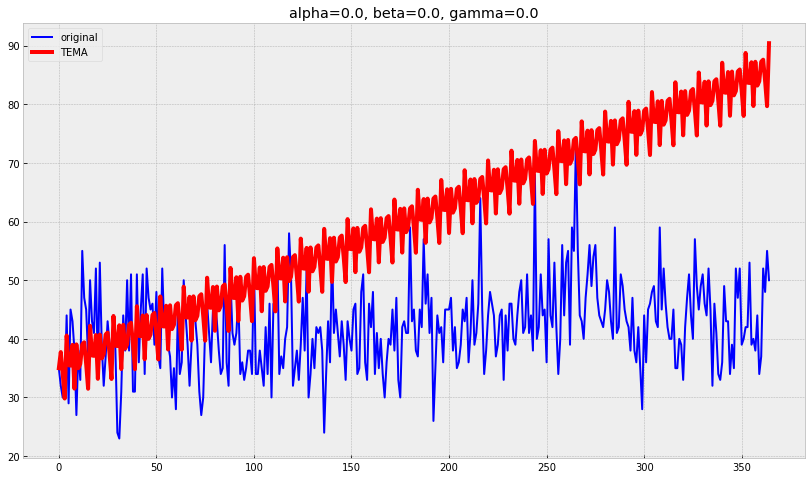

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

### Вывод:
Лучше всего использовать DEMA, не учитывая сезонность в стационарном ряде(как в модели Хольтера-Винтерса), мы лучше описываем данные и делаем прогноз

# Изучим не стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


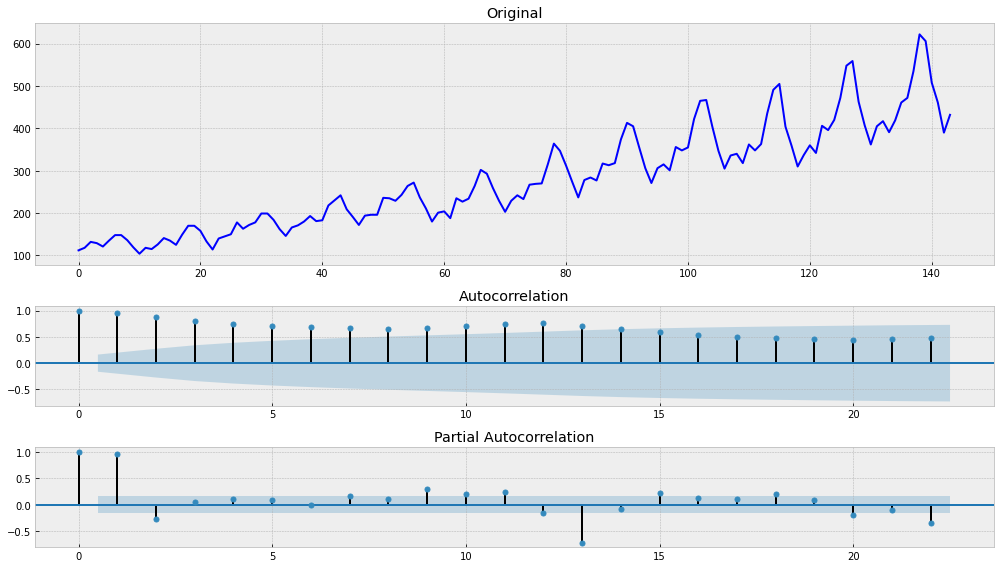

In [ ]:
tsplot(airline_passengers['Count'])

## MA - скользящее среднее

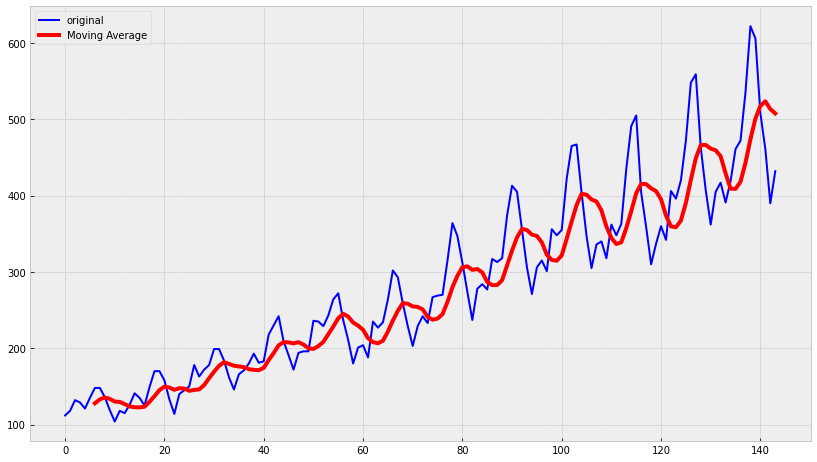

In [ ]:
ser = moving_average(airline_passengers['Count'], 7)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airline_passengers['Count'], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

## WMA - взвешенная скользящая средняя

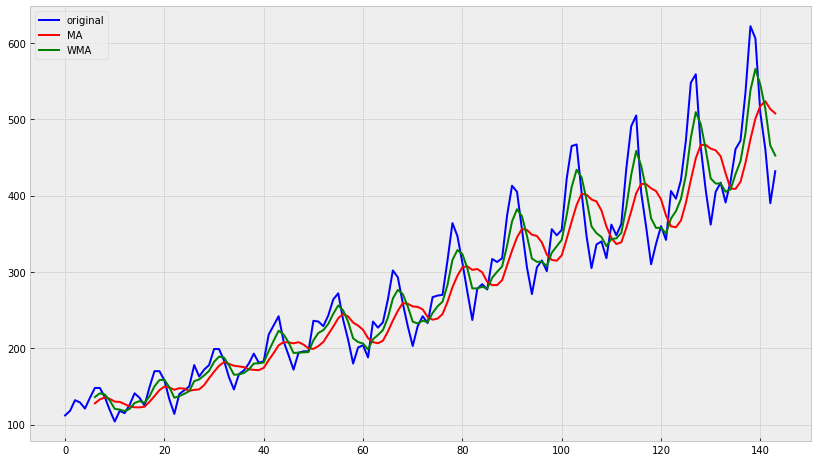

In [ ]:
wma = weighted_moving_average(airline_passengers['Count'], 7, [1,1,2,3,5,8,13])
ma = moving_average(airline_passengers['Count'], 7)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airline_passengers['Count'], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

## EMA - экспоненциальное сглаживание

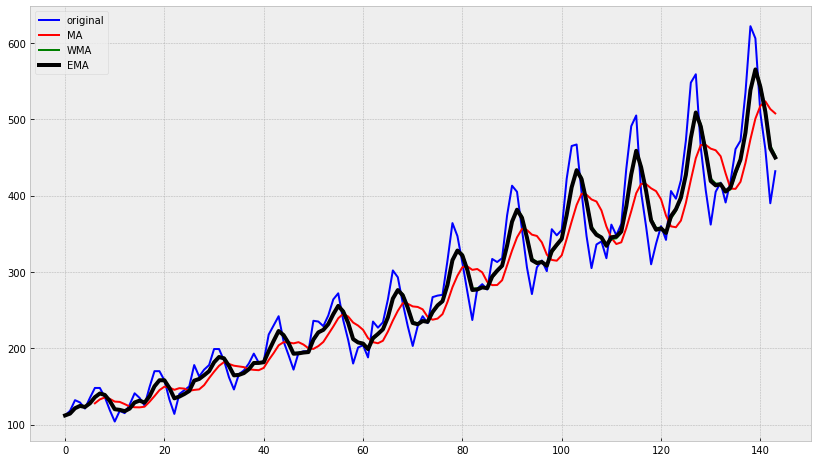

In [ ]:
ema = exponential_moving_average(airline_passengers['Count'], 0.4)
wma = weighted_moving_average(airline_passengers['Count'], 7, [1,1,2,3,5,8,13])
ma = moving_average(airline_passengers['Count'], 7)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airline_passengers['Count'], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

## DEMA - двойное экспоненциальное сглаживание

In [ ]:
def plot_dema(alpha, beta):
    dema = double_ema(airline_passengers['Count'], alpha, beta)

    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(airline_passengers['Count'], color='blue',label='original')
        plt.plot(dema, color='purple', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

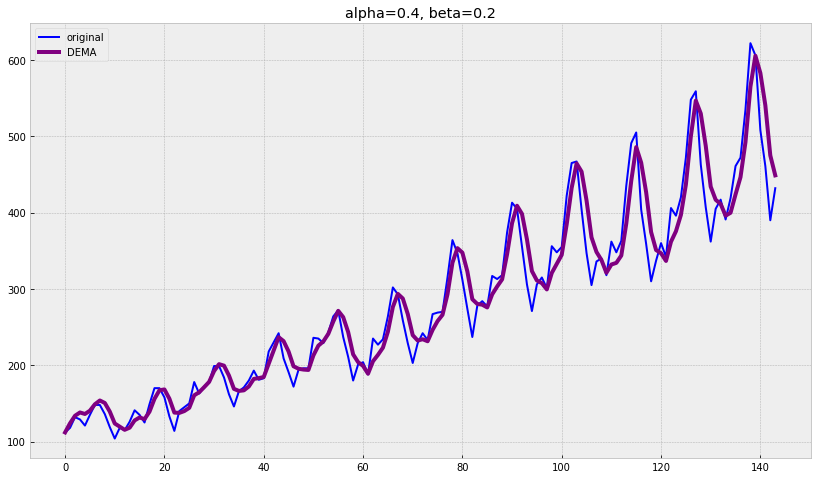

In [ ]:
plot_dema(0.4, 0.2)

## TEMA - Хольт-Винтерс (учтем сезонность)

In [ ]:
def plot_tema(alpha, beta, gamma, ser=airline_passengers['Count'], ser_to_plot=airline_passengers['Count'], n_preds=10):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

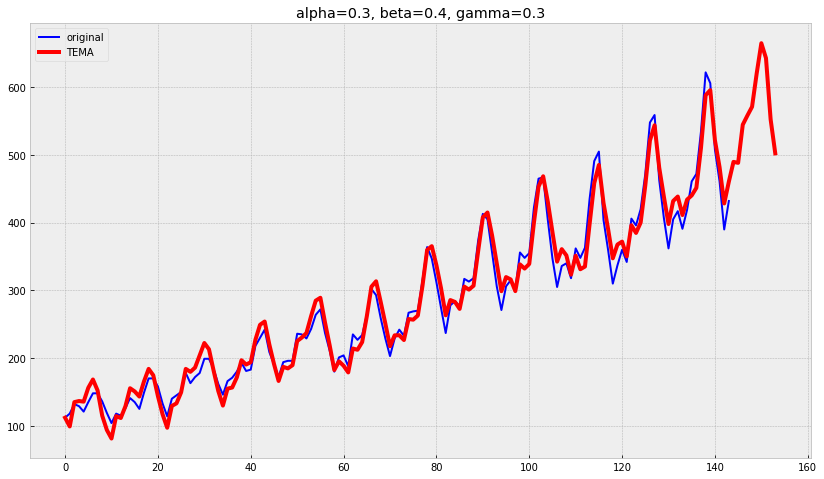

In [ ]:
plot_tema(0.3, 0.4, 0.3)

## Подбор параметров

In [ ]:
series_ = airline_passengers["Count"]
train, test, val = series[:60], series[60:70], series[70:]

In [ ]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 64.21043518518334
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([524.85726911,   0.        ,  63.47764554])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([0., 0., 0.])


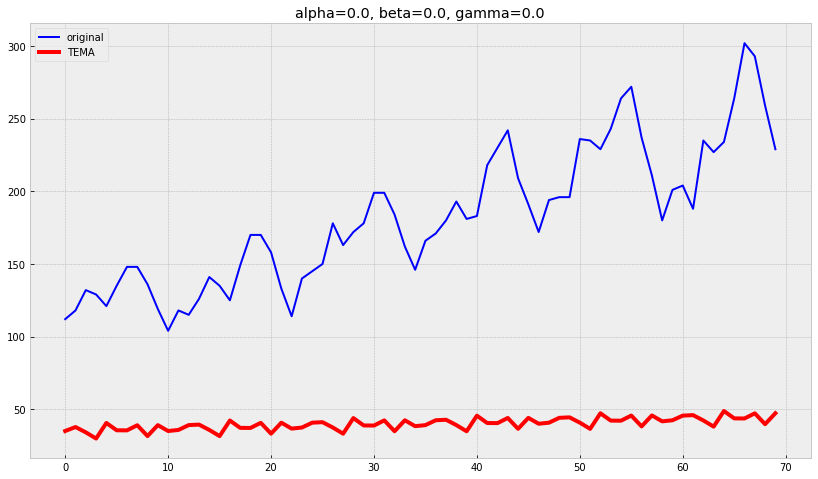

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_[:70], n_preds=len(test))

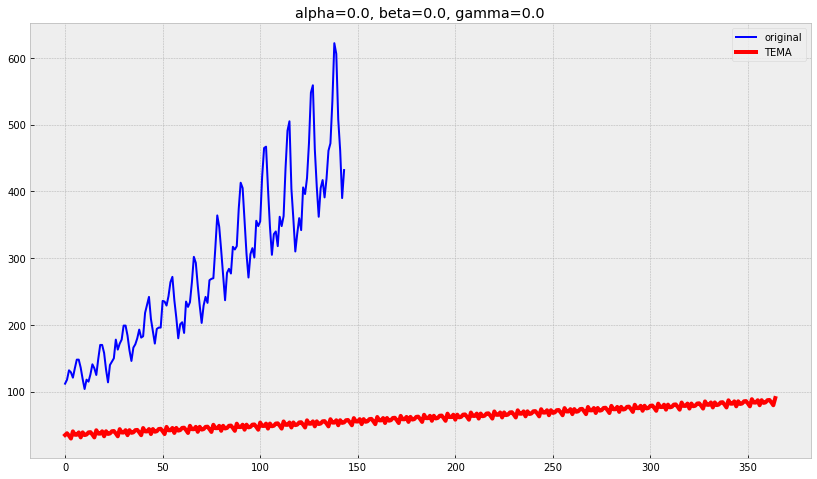

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series_, n_preds=len(val))

## Кросс-валидация

In [ ]:
train, val = series_[:50], series_[50:]

from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [ ]:
#opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
opt = minimize(mse_cross_val, x0=[0.3,0.4,0.3], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

171.76608386492467------------
171.76607617192167------------
171.76608622197304------------
171.76608771027892------------
188.27042341820982------------
188.27042335787579------------
188.2703450877008------------
188.27042341820982------------
175.6185037364846------------
175.61850805370992------------
175.6185167084625------------
175.61850175004042------------
119.1772057814196------------
119.17720948783682------------
119.1772091323777------------
119.17720481974807------------
109.08718470807646------------
109.08718469458954------------
109.08718641506205------------
109.0871849837096------------
100.1914466504233------------
100.19144635616713------------
100.19144835134------------
100.19144705857117------------
108.49055051555557------------
108.49054889053161------------
108.49054088884562------------
108.49055101882288------------
86.05628512634998------------
86.05628478270245------------
86.056285638716------------
86.0562854718974------------
95.41868836479273--------

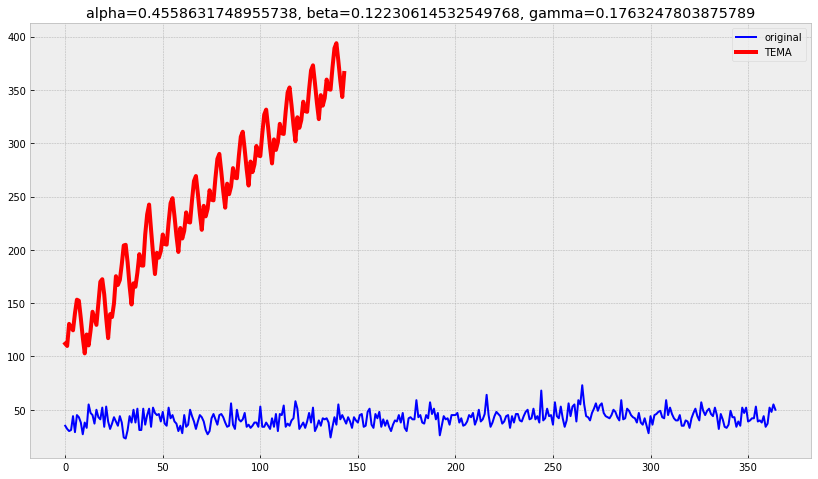

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

### Вывод:
В этом ряде лучше использовать модель Хольте-Винтерса, т.к. она учитывает сезонность и тренд